
## Using k-means to show which districts has the most number of airbnb listings in london

In [89]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from shapely.geometry import Point
import matplotlib.pyplot as plt
'''neighbourhood data'''

# Load Airbnb data
file_path = 'london_airbnb_data.csv'  # Update this path
data = pd.read_csv(file_path)

# Perform k-means clustering with k=32 on the original lat, lng data
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(data[['lat', 'lng']])
data['cluster_label'] = clusters

# Convert the Airbnb data to a GeoDataFrame using WGS 84 CRS
gdf_airbnb = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lng, data.lat), crs='EPSG:4326')

# Load the London boroughs or wards shapefile
path_to_shapefile = 'London-wards-2018_ESRI/London_Ward.shp'  # Update this path
london_wards = gpd.read_file(path_to_shapefile).to_crs('EPSG:4326')  # Assuming the shapefile is in WGS 84

# Spatial join to associate listings with wards/boroughs
# Ensure the CRS matches; if the wards shapefile is not in WGS 84, transform it before joining
airbnb_with_wards = gpd.sjoin(gdf_airbnb, london_wards, how="inner", predicate='intersects')

# Assuming 'NAME' column in london_wards GeoDataFrame contains the borough names
airbnb_with_wards['Ward'] = airbnb_with_wards['NAME']

# Create a base map
m = folium.Map(location=[data['lat'].mean(), data['lng'].mean()], zoom_start=10, tiles='CartoDB positron')

# Use MarkerCluster to cluster the points
marker_cluster = MarkerCluster().add_to(m)

# Iterate through the DataFrame and add each listing to the map
for idx, row in airbnb_with_wards.iterrows():
    location = [row['lat'], row['lng']]
    tooltip = f"Cluster: {row['cluster_label']}, Neighbourhood: {row['NAME']}"
    folium.Marker(location, tooltip=tooltip).add_to(marker_cluster)

# Display the map
m

# Save the map as an HTML file
#m.save('london_airbnb_clusters.html')

# Analyze the most common borough for each cluster
cluster_borough_counts = airbnb_with_wards.groupby(['cluster_label', 'NAME', 'DISTRICT']).size().reset_index(name='counts')
most_common_boroughs = cluster_borough_counts.loc[cluster_borough_counts.groupby(['cluster_label'])['counts'].idxmax()]

sorted_data = most_common_boroughs.sort_values(by='counts', ascending=False)
print(sorted_data.to_string(index=False))



/Users/vishal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 cluster_label                     NAME               DISTRICT  counts
            14              Whitechapel          Tower Hamlets     327
             9           Lancaster Gate    City of Westminster     180
             0                 West End    City of Westminster     153
             4               Courtfield Kensington and Chelsea     118
             8                 Bow East          Tower Hamlets     109
             6               Caledonian              Islington     107
             2 Hoxton East & Shoreditch                Hackney     101
             1  Blackwall & Cubitt Town          Tower Hamlets      91
            11                 Bishop's                Lambeth      91
            13                 Graveney             Wandsworth      87
             3 Avonmore and Brook Green Hammersmith and Fulham      72
             7             Brixton Hill                Lambeth      72
            10              Southfields             Wandsworth      63
      

## Bar chart to show number of airbnb listings within each district

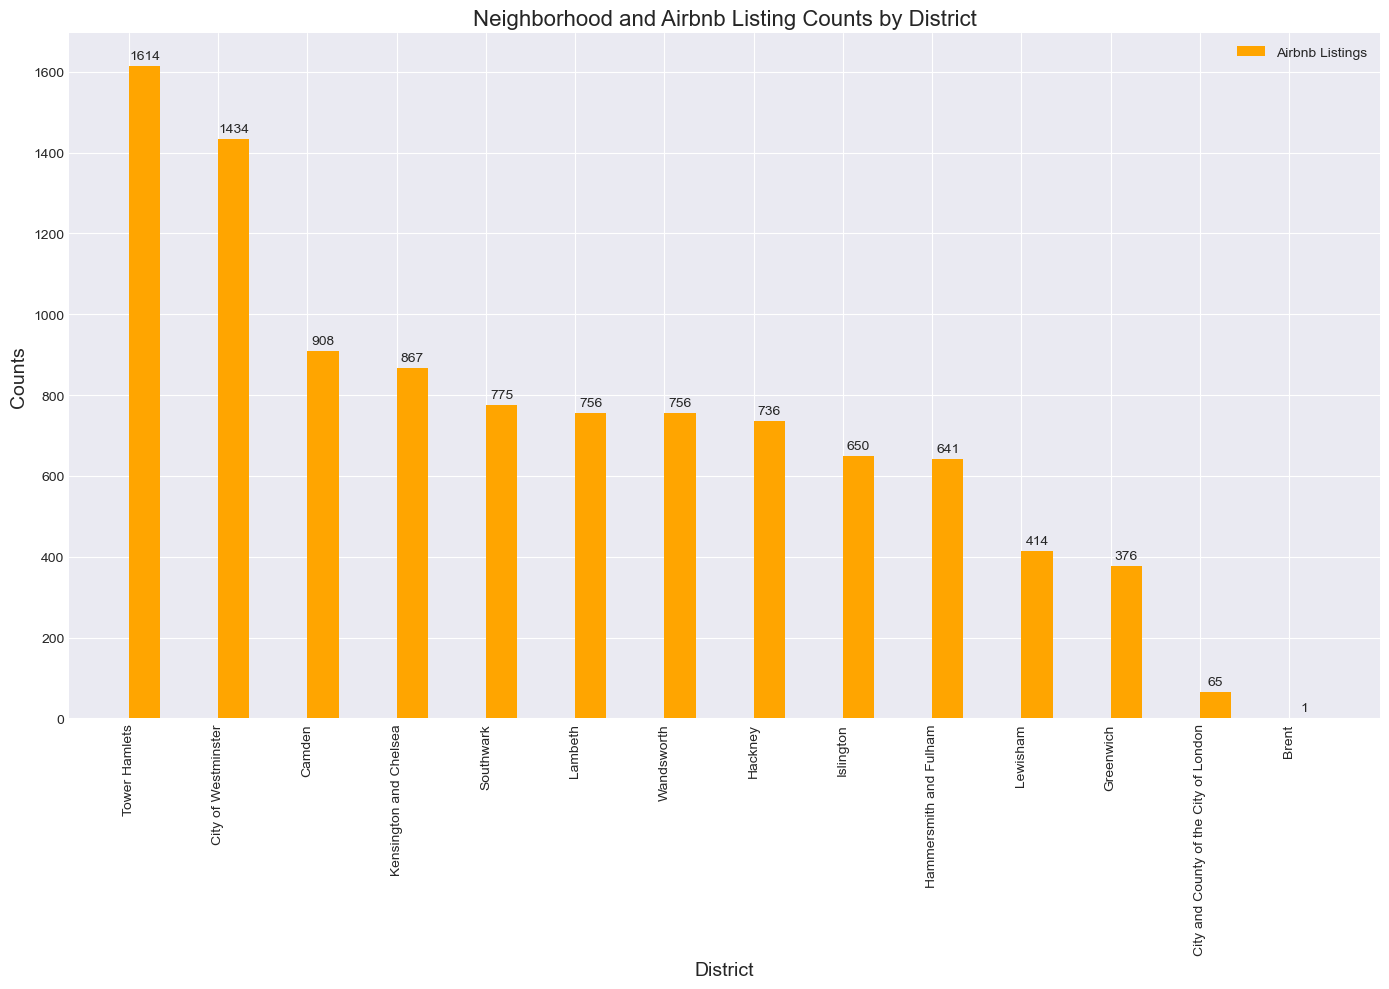

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the dataset
wards_data_path = 'wards.csv'  # Replace with your file path
wards_data = pd.read_csv(wards_data_path)

# Group by 'DISTRICT' and count the number of unique neighborhoods and total Airbnb listings
district_summary = wards_data.groupby('DISTRICT').agg(
    Neighborhood_Count=('borough_name', 'nunique'),  # Count unique neighborhoods
    Airbnb_Listings=('borough_name', 'size')         # Count total listings
).reset_index()

# Sort by 'Airbnb_Listings' in descending order
district_summary_sorted = district_summary.sort_values(by='Airbnb_Listings', ascending=False)

# Drop the index for the final display
district_summary_sorted_no_index = district_summary_sorted.reset_index(drop=True)

# Display the sorted dataframe without the index
#print(district_summary_sorted_no_index)


# Setting up the figure and axes for the grouped bar chart
fig, ax = plt.subplots(figsize=(14, 10))

# Define the positions for the bars
index = np.arange(len(district_summary_sorted_no_index['DISTRICT']))
bar_width = 0.35

# Plotting both the Neighborhood Count and Airbnb Listings as side-by-side bars
bars2 = ax.bar(index + bar_width/2, district_summary_sorted_no_index['Airbnb_Listings'], bar_width, label='Airbnb Listings', color='orange')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('District', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Neighborhood and Airbnb Listing Counts by District', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(district_summary_sorted_no_index['DISTRICT'], rotation=90)
ax.legend()

# Function to add labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adding labels to the bars

add_labels(bars2)

# Show the plot
plt.tight_layout()  # Adjust layout to fit all x-axis labels
plt.show()




## Interactive map for airbnb listings in london

In [91]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from shapely.geometry import Point

'''neighbourhood data'''

# Load Airbnb data
file_path = 'london_airbnb_data.csv'  # Update this path
data = pd.read_csv(file_path)

# Perform k-means clustering with k=32 on the original lat, lng data
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(data[['lat', 'lng']])
data['cluster_label'] = clusters

# Convert the Airbnb data to a GeoDataFrame using WGS 84 CRS
gdf_airbnb = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lng, data.lat), crs='EPSG:4326')

# Load the London boroughs or wards shapefile
path_to_shapefile = 'London-wards-2018_ESRI/London_Ward.shp' 
london_wards = gpd.read_file(path_to_shapefile).to_crs('EPSG:4326')  # Assuming the shapefile is in WGS 84

# Spatial join to associate listings with wards/boroughs
# Ensure the CRS matches; if the wards shapefile is not in WGS 84, transform it before joining
airbnb_with_wards = gpd.sjoin(gdf_airbnb, london_wards, how="inner", predicate='intersects')

# Assuming 'NAME' column in london_wards GeoDataFrame contains the borough names
airbnb_with_wards['Ward'] = airbnb_with_wards['NAME']

# Create a base map
m = folium.Map(location=[data['lat'].mean(), data['lng'].mean()], zoom_start=10, tiles='CartoDB positron')

# Use MarkerCluster to cluster the points
marker_cluster = MarkerCluster().add_to(m)

# Iterate through the DataFrame and add each listing to the map
for idx, row in airbnb_with_wards.iterrows():
    location = [row['lat'], row['lng']]
    tooltip = f"Cluster: {row['cluster_label']}, Neighbourhood: {row['NAME']}"
    folium.Marker(location, tooltip=tooltip).add_to(marker_cluster)

# Display the map
m

/Users/vishal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Average price per night in given districts 

In [109]:
import pandas as pd

# Load the dataset
data_path = 'wards.csv'  # Adjust this to the path of your dataset
wards_data = pd.read_csv(data_path)

# Grouping data by district to calculate the average price
average_price_by_district = wards_data.groupby('DISTRICT').agg({
    'realSum': 'mean'  # Assuming 'realSum' represents the listing price
}).rename(columns={'realSum': 'Average_Price'})

# Sorting the results by average price in descending order
average_price_by_district_sorted = average_price_by_district.sort_values(by='Average_Price', ascending=False)

# Resetting index to make 'DISTRICT' a column for easier analysis
average_price_by_district_sorted.reset_index(inplace=True)

# Displaying the sorted average prices by district
print(average_price_by_district_sorted.head(20))


                                 DISTRICT  Average_Price
0                     City of Westminster     564.185876
1   City and County of the City of London     520.961670
2                  Kensington and Chelsea     507.494946
3                                  Camden     419.196632
4                               Islington     347.590489
5                               Southwark     327.801537
6                                 Hackney     314.294594
7                  Hammersmith and Fulham     310.849377
8                           Tower Hamlets     301.349352
9                                   Brent     292.339895
10                                Lambeth     271.483051
11                             Wandsworth     264.644838
12                              Greenwich     215.468754
13                               Lewisham     181.321610


## Bar chart showing Average Airbnb Price by District in London

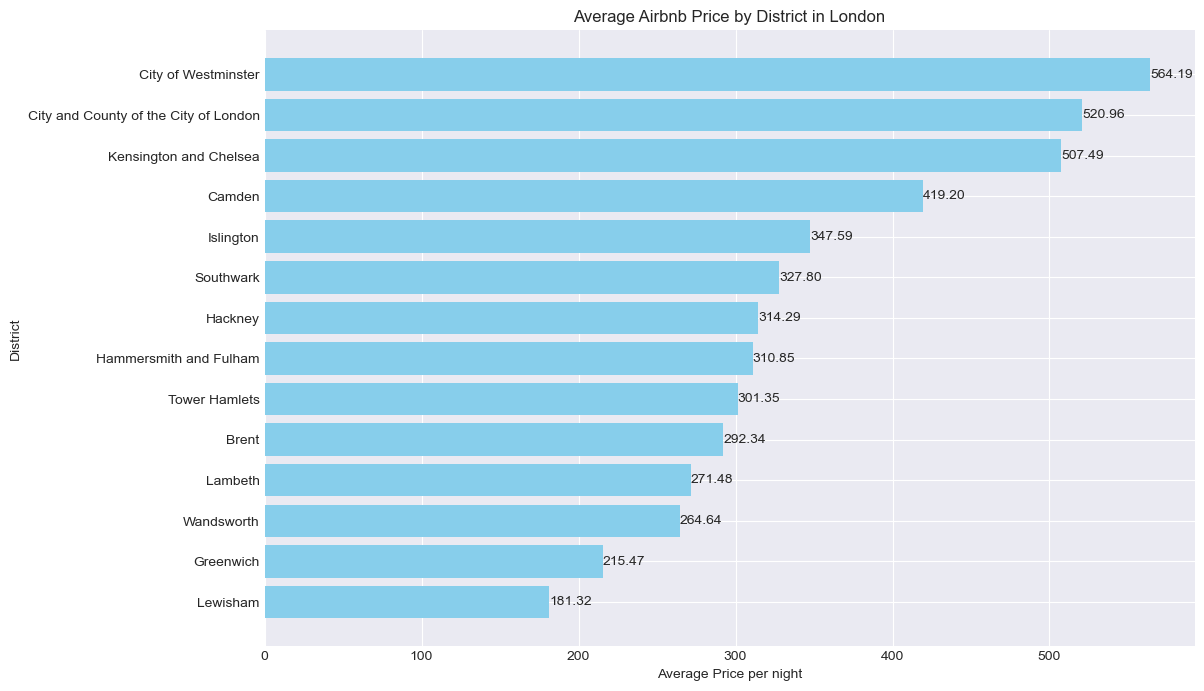

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data_path = 'wards.csv'  # Adjust this to the path of your dataset
wards_data = pd.read_csv(data_path)

# Calculating the average price by district
average_price_by_district = wards_data.groupby('DISTRICT').agg({
    'realSum': 'mean'  # Assuming 'realSum' represents the listing price
}).rename(columns={'realSum': 'Average_Price'}).sort_values(by='Average_Price', ascending=False)

# Resetting index to make 'DISTRICT' a column
average_price_by_district.reset_index(inplace=True)

# Creating the bar chart with average prices labeled
plt.figure(figsize=(12, 8))
bars = plt.barh(average_price_by_district['DISTRICT'], average_price_by_district['Average_Price'], color='skyblue')

# Adding the data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}",
             va='center', ha='left')

plt.xlabel('Average Price per night')
plt.ylabel('District')
plt.title('Average Airbnb Price by District in London')
plt.gca().invert_yaxis()  # To display the highest price at the top
plt.show()


## Calculating average metro distances per district 

In [95]:
import pandas as pd

# Load your dataset
data_path = 'wards.csv'  # Replace with the path to your dataset
wards_data = pd.read_csv(data_path)

# Perform the analysis of metro distance by district
metro_access_analysis = wards_data.groupby('DISTRICT')['metro_dist'].agg(['mean', 'min', 'max', 'std']).reset_index()

# Sorting by average metro distance (mean) in ascending order for better public transport accessibility
metro_access_analysis_sorted = metro_access_analysis.sort_values('mean')

# Display the sorted analysis results
print(metro_access_analysis_sorted)

                                 DISTRICT      mean       min       max  \
2   City and County of the City of London  0.235280  0.054730  0.455897   
3                     City of Westminster  0.320899  0.020481  0.860795   
1                                  Camden  0.387528  0.028694  1.334045   
8                  Kensington and Chelsea  0.439312  0.032772  1.338775   
0                                   Brent  0.466908  0.466908  0.466908   
6                  Hammersmith and Fulham  0.470888  0.045969  1.489265   
7                               Islington  0.600677  0.025447  1.754082   
12                          Tower Hamlets  0.646545  0.039524  1.992394   
9                                 Lambeth  1.083146  0.013875  5.229598   
13                             Wandsworth  1.110839  0.055051  2.882736   
11                              Southwark  1.244454  0.034659  4.801408   
5                                 Hackney  1.476479  0.082848  3.234763   
4                        

## Bar chart showing Average Distance to Nearest Metro Station by District

/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_84092/1341705140.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


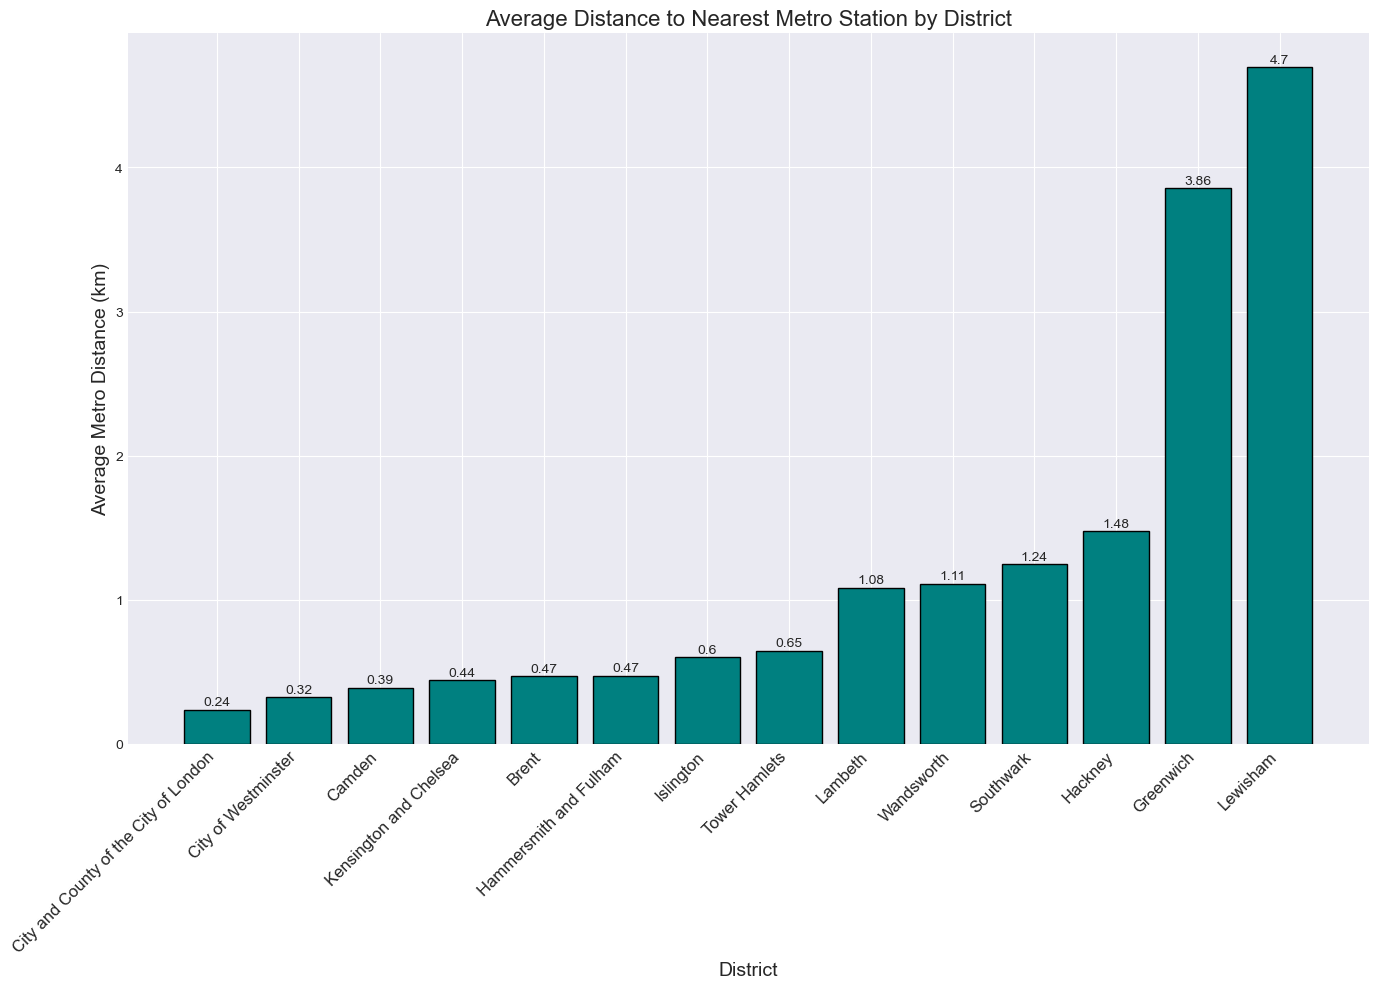

In [96]:
import pandas as pd
import matplotlib.pyplot as plt


# Set a style (
plt.style.use('seaborn-darkgrid')

# Increase the figure size and resolution
plt.figure(figsize=(14, 10), dpi=100)

# Creating the bar chart with improved aesthetics
bars = plt.bar(metro_access_analysis_sorted['DISTRICT'], metro_access_analysis_sorted['mean'], color='teal', edgecolor='black')

# Adding labels and title with an increased font size for clarity
plt.xlabel('District', fontsize=14)
plt.ylabel('Average Metro Distance (km)', fontsize=14)
plt.title('Average Distance to Nearest Metro Station by District', fontsize=16)

# Rotate district names for better readability and adjust font size
plt.xticks(rotation=45, ha="right", fontsize=12)

# Adding the average distance values on top of each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Optionally, if you want to save the figure with high quality
plt.tight_layout()
plt.savefig('metro_distance_by_district.png', dpi=300)  # Save as PNG with high DPI

plt.show()


In [97]:
import pandas as pd

# Load the dataset
wards_data_path = 'wards.csv'  # Replace with your file path
wards_data = pd.read_csv(wards_data_path)

# Group by 'DISTRICT' and calculate the required metrics
district_analysis = wards_data.groupby('DISTRICT').agg(
    neighborhood_count=('borough_name', 'nunique'),  # Count unique neighborhoods
    average_attr_index=('attr_index', 'mean'),        # Average attraction index
    average_rest_index=('rest_index', 'mean')         # Average restaurant index
).reset_index()

# Sort by average attraction index and average restaurant index in descending order
district_analysis_sorted = district_analysis.sort_values(
    by=['average_attr_index', 'average_rest_index'], 
    ascending=False
)

# Display the sorted dataframe
print(district_analysis_sorted)


                                 DISTRICT  neighborhood_count  \
2   City and County of the City of London                  16   
3                     City of Westminster                  20   
1                                  Camden                  18   
11                              Southwark                  23   
8                  Kensington and Chelsea                  18   
7                               Islington                  16   
9                                 Lambeth                  21   
12                          Tower Hamlets                  20   
5                                 Hackney                  21   
6                  Hammersmith and Fulham                  16   
13                             Wandsworth                  20   
0                                   Brent                   1   
10                               Lewisham                  18   
4                               Greenwich                  17   

    average_attr_index  

## Average Attraction and Restaurant Indices by District

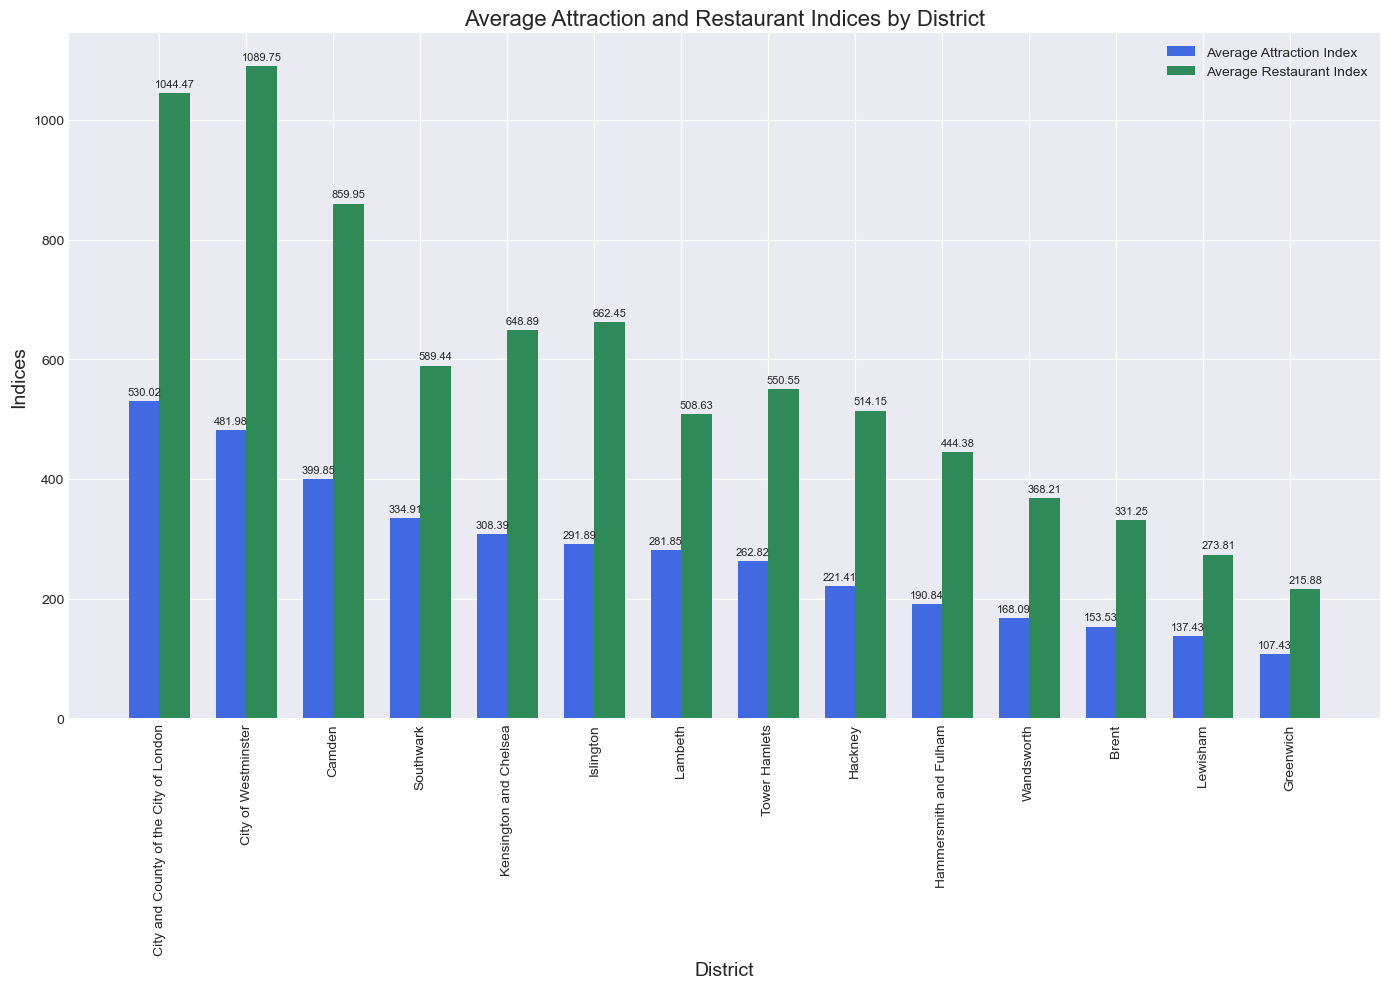

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data_path = 'wards.csv'  # Replace with your file path
wards_data = pd.read_csv(data_path)

# Group by 'DISTRICT' and calculate the required metrics
district_analysis = wards_data.groupby('DISTRICT').agg(
    neighborhood_count=('borough_name', 'nunique'),  # Count unique neighborhoods
    average_attr_index=('attr_index', 'mean'),        # Average attraction index
    average_rest_index=('rest_index', 'mean')         # Average restaurant index
).reset_index()

# Sort by average attraction index and average restaurant index in descending order
district_analysis_sorted = district_analysis.sort_values(
    by=['average_attr_index', 'average_rest_index'], 
    ascending=False
)

# Setting up the figure and axis for the grouped bar chart
fig, ax = plt.subplots(figsize=(14, 10))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(district_analysis_sorted))

# Plotting both 'average_attr_index' and 'average_rest_index'
bar1 = ax.bar(index, district_analysis_sorted['average_attr_index'], bar_width, label='Average Attraction Index', color='royalblue')
bar2 = ax.bar(index + bar_width, district_analysis_sorted['average_rest_index'], bar_width, label='Average Restaurant Index', color='seagreen')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('District', fontsize=14)
ax.set_ylabel('Indices', fontsize=14)
ax.set_title('Average Attraction and Restaurant Indices by District', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(district_analysis_sorted['DISTRICT'], rotation=90)
ax.legend()


for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Show the plot
plt.tight_layout()  # Adjust layout to fit all x-axis labels
plt.show()

